In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import ltn
import networkx as nx
import itertools

# Data

Parent relationships (the knowledge is assumed complete).

In [2]:
entities = ["sue", "diana", "john", "edna", "paul", "francis", "john2",
                "john3", "john4", "joe", "jennifer", "juliet", "janice",
                "joey", "tom", "bonnie", "katie"]

parents = [
        ("sue", "diana"),
        ("john", "diana"),
        ("sue", "bonnie"),
        ("john", "bonnie"),
        ("sue", "tom"),
        ("john", "tom"),
        ("diana", "katie"),
        ("paul", "katie"),
        ("edna", "sue"),
        ("john2", "sue"),
        ("edna", "john3"),
        ("john2", "john3"),
        ("francis", "john"),
        ("john4", "john"),
        ("francis", "janice"),
        ("john4", "janice"),
        ("janice", "jennifer"),
        ("joe", "jennifer"),
        ("janice", "juliet"),
        ("joe", "juliet"),
        ("janice", "joey"),
        ("joe", "joey")]

all_relationships = list(itertools.product(entities, repeat=2))
not_parents = [item for item in all_relationships if item not in parents]

Visualized in a graph.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


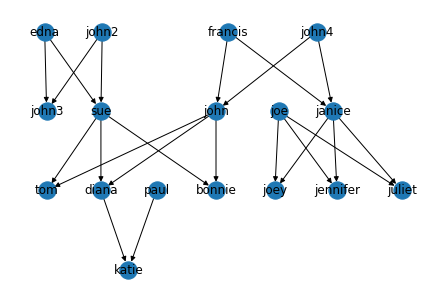

In [3]:
# Ground Truth Parents
parDG_truth = nx.DiGraph(parents)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(parDG_truth,pos,with_labels=True)

Ancestor relationships and visualization in a graph.

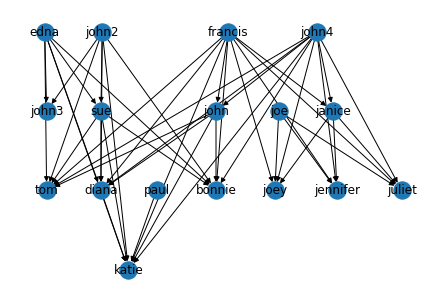

In [4]:
# Ground Truth Ancestors
def get_descendants(entity, DG):
    all_d = []
    direct_d = list(DG.successors(entity))
    all_d += direct_d
    for d in direct_d:
        all_d += get_descendants(d, DG)
    return all_d

ancestors = []
for e in entities:
    for d in get_descendants(e, parDG_truth):
        ancestors.append((e,d))

ancDG_truth = nx.DiGraph(ancestors)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(ancDG_truth,pos,with_labels=True)

# LTN

Every individual is grounded as a trainable LTN constant in $\mathbb{R}^2$. The grounding of the predicates `Parent` and `Ancestor` (modelled by multi-layer perceptrons) are learned at the same times as the embeddings for the individuals.

We give the complete parent relationships in the knowledgebase. However, we don't give any ancestor relationships; they are to be inferred using a set of rules.

In [5]:
embedding_size = 4

Ancestor = ltn.Predicate.MLP([embedding_size,embedding_size],hidden_layer_sizes=[8,8])
Parent = ltn.Predicate.MLP([embedding_size,embedding_size],hidden_layer_sizes=[8,8])

g_e = {
    l: ltn.Constant(np.random.uniform(low=0.,high=1.,size=embedding_size), trainable=True) 
    for l in entities
}


2021-08-31 03:56:50.535005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 03:56:50.542057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 03:56:50.542402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 03:56:50.543032: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Knowledge Base

In [6]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=5),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=5),semantics="exists")

In [7]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=5))

# defining the theory
@tf.function
def axioms():
    # Variables created in the training loop, so tf.GradientTape
    # keeps track of the connection with the trainable constants.
    a = ltn.Variable.from_constants("a",list(g_e.values()))
    b = ltn.Variable.from_constants("b",list(g_e.values()))
    c = ltn.Variable.from_constants("c",list(g_e.values()))

    ## Complete knowledge about parent relationships.
    ## The ancestor relationships are to be learned with these additional rules.
    axioms = [
        # forall pairs of individuals in the parent relationships: Parent(ancestor,child)
        Parent([g_e[a],g_e[c]])
        for a,c in parents
    ] + \
    [
        # forall pairs of individuals not in the parent relationships: Not(Parent([n_parent,n_child])))
        Not(Parent([g_e[a],g_e[c]]))
        for a,c in not_parents
    ] + \
    [
        # if a is parent of b, then a is ancestor of b
        Forall((a,b), Implies(Parent([a,b]),Ancestor([a,b]))),
        # parent is anti reflexive
        Forall(a, Not(Parent([a,a]))),
        # ancestor is anti reflexive
        Forall(a, Not(Ancestor([a,a]))),
        # parent is anti symmetric
        Forall((a,b), Implies(Parent([a,b]),Not(Parent([b,a])))),
        # if a is parent of an ancestor of c, a is an ancestor of c too  
        Forall(
            (a,b,c),
            Implies(And(Parent([a,b]),Ancestor([b,c])), Ancestor([a,c])),
            p=6
        ),
        # if a is an ancestor of b, a is a parent of b OR a parent of an ancestor of b
        Forall(
            (a,b),
            Implies(Ancestor([a,b]), 
                    Or(Parent([a,b]), 
                       Exists(c, And(Ancestor([a,c]),Parent([c,b])),p=6)
                      )
                   )
        )
    ]    
    # computing sat_level
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

print("Initial sat level %.5f"%axioms())

2021-08-31 03:57:05.597658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Initial sat level 0.56156


Training

In [8]:
trainable_variables = \
        Parent.trainable_variables\
        +Ancestor.trainable_variables \
        +ltn.as_tensors(list(g_e.values()))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [9]:
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms()
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()))

Epoch 0: Sat Level 0.563
Epoch 200: Sat Level 0.607
Epoch 400: Sat Level 0.651
Epoch 600: Sat Level 0.806
Epoch 800: Sat Level 0.918
Epoch 1000: Sat Level 0.934
Epoch 1200: Sat Level 0.935
Epoch 1400: Sat Level 0.935
Epoch 1600: Sat Level 0.936
Epoch 1800: Sat Level 0.936
Epoch 2000: Sat Level 0.936
Epoch 2200: Sat Level 0.936
Epoch 2400: Sat Level 0.936
Epoch 2600: Sat Level 0.936
Epoch 2800: Sat Level 0.936
Training finished at Epoch 2999 with Sat Level 0.936


# Querying additional axioms

Additional axioms:
1. forall a,b,c: (Ancestor(a,b) & Parent(b,c)) -> Ancestor (a,c)
2. forall a,b: Ancestor(a,b) -> ~Ancestor(b,a)
3. forall a,b,c: (Parent(a,b) & Parent(b,c)) -> Ancestor(a,c)
4. forall a,b,c: (Ancestor(a,b) & Ancestor(b,c)) -> Ancestor(a,c)

In [10]:
a = ltn.Variable.from_constants("a",list(g_e.values()))
b = ltn.Variable.from_constants("b",list(g_e.values()))
c = ltn.Variable.from_constants("c",list(g_e.values()))

In [11]:
Forall((a,b,c), 
       Implies(And(Ancestor([a,b]),Parent([b,c])), Ancestor([a,c]))
).tensor

<tf.Tensor: shape=(), dtype=float32, numpy=0.77405727>

In [12]:
Forall((a,b), 
       Implies(Ancestor([a,b]), Not(Ancestor([b,a])))
).tensor

<tf.Tensor: shape=(), dtype=float32, numpy=0.9937977>

In [13]:
Forall((a,b,c),
       Implies(And(Parent([a,b]),Parent([b,c])), Ancestor([a,c]))
).tensor

<tf.Tensor: shape=(), dtype=float32, numpy=0.77823627>

In [14]:
Forall((a,b,c),
       Implies(And(Parent([a,b]),Parent([b,c])), Ancestor([a,c]))
).tensor

<tf.Tensor: shape=(), dtype=float32, numpy=0.77823627>

# Visualize Results

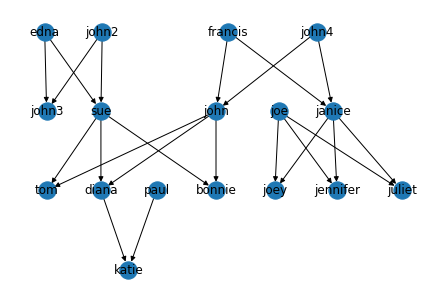

In [15]:
threshold = 0.5
parents_test = [
    (e1,e2) for e1 in entities for e2 in entities
    if (Parent([g_e[e1],g_e[e2]]).tensor.numpy() > 0.5)
]

parDG_test = nx.DiGraph(parents_test)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(parDG_test,pos,with_labels=True)

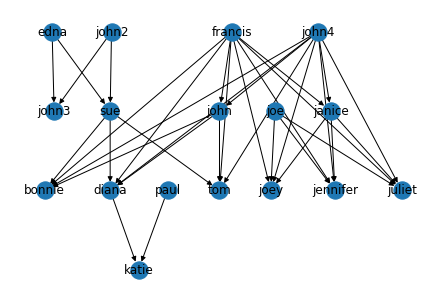

In [16]:
threshold = 0.5
ancestors_test = [
    (e1,e2) for e1 in entities for e2 in entities
    if (Ancestor([g_e[e1],g_e[e2]]).tensor.numpy() > 0.5)
]

ancDG_test = nx.DiGraph(ancestors_test)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_test, prog='dot')
nx.draw(ancDG_test,pos,with_labels=True)